### Ensamble Learning?
- 여러 개의 분류기(Classifier)를 생성하고, 그 예측을 결합함으로써 더 정확한 예측을 도출하는 기법
- 다수 모델들을 결합하여 단일 모델을 보완
- 성능이 떨어지지만 서로 다른 유형의 모델들을 섞으면 오히려 성능이 향상되기도 함

### Voting and Bagging
- 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식
- Voting : 서로 다른 알고리즘을 가진 분류기가 같은 데이터 셋을 기반으로 학습
- Bagging : 같은 알고리즘 유형의 모델들이지만 데이터 샘플링을 다르게 하여 학습 (단, 교차 검증과는 다르게 데이터 세트간의 중첩을 허용)

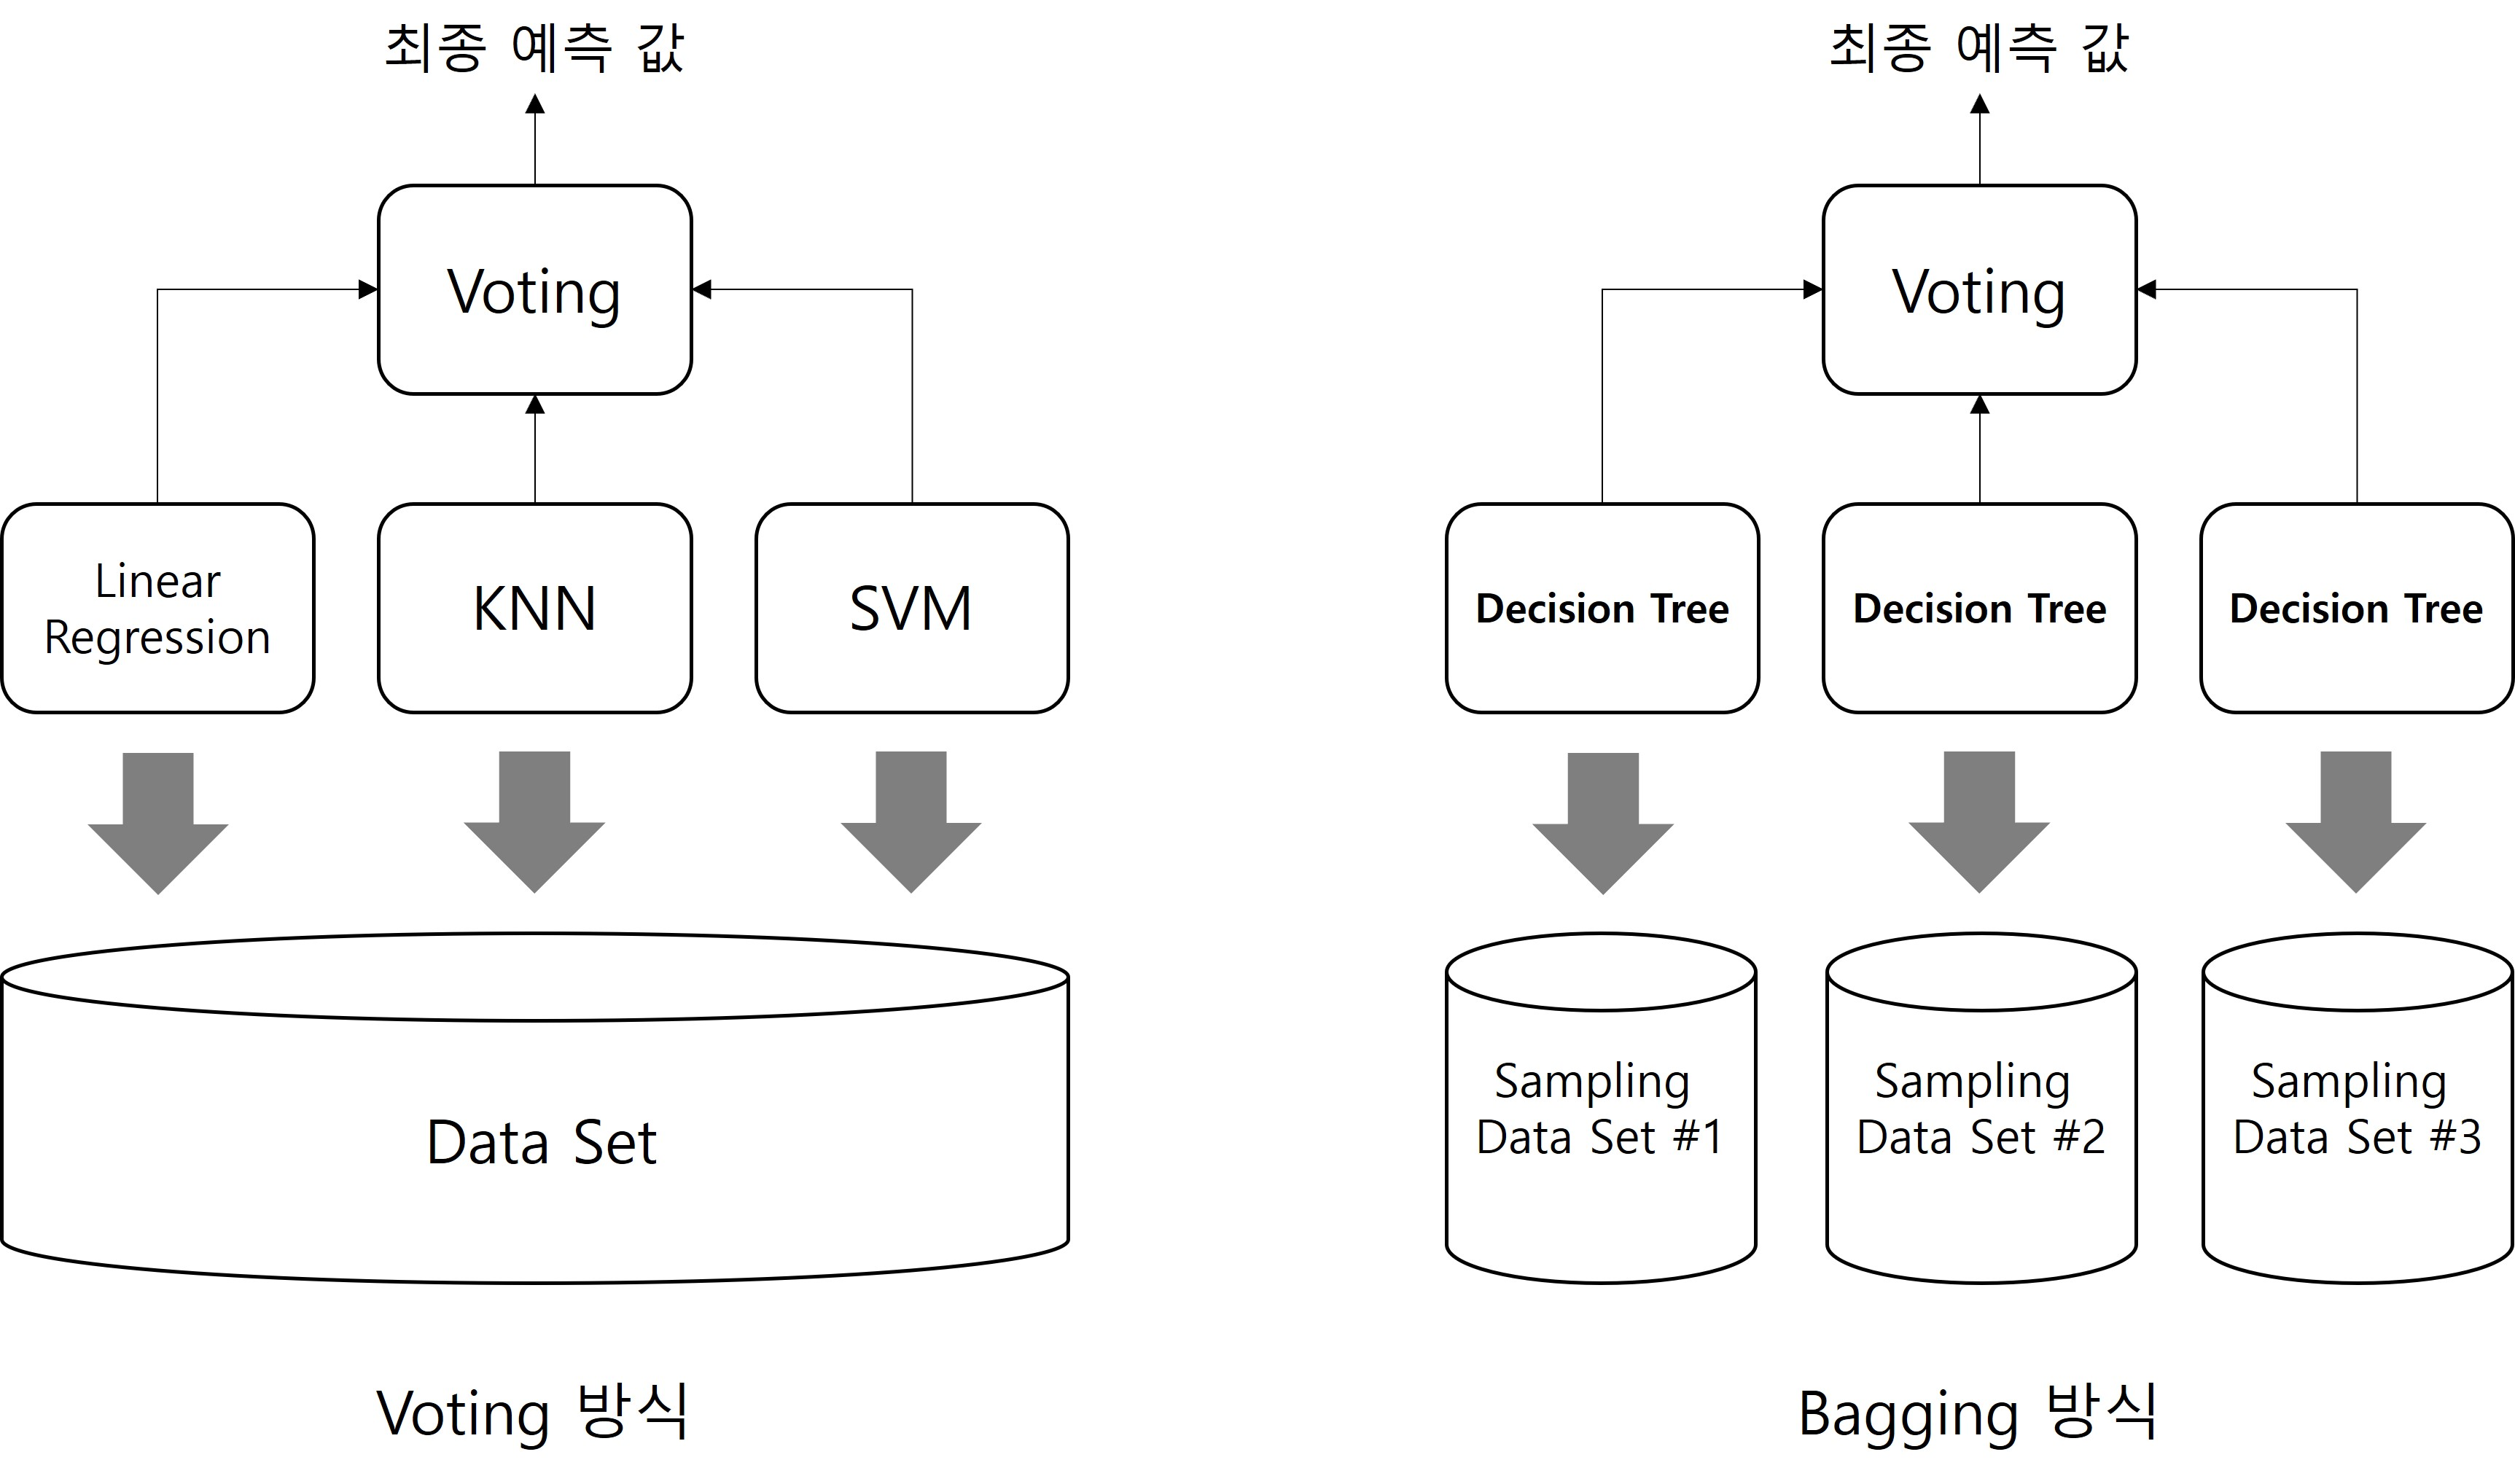

In [4]:
from IPython.display import Image
Image('voting_bagging.jpg', width = 500)

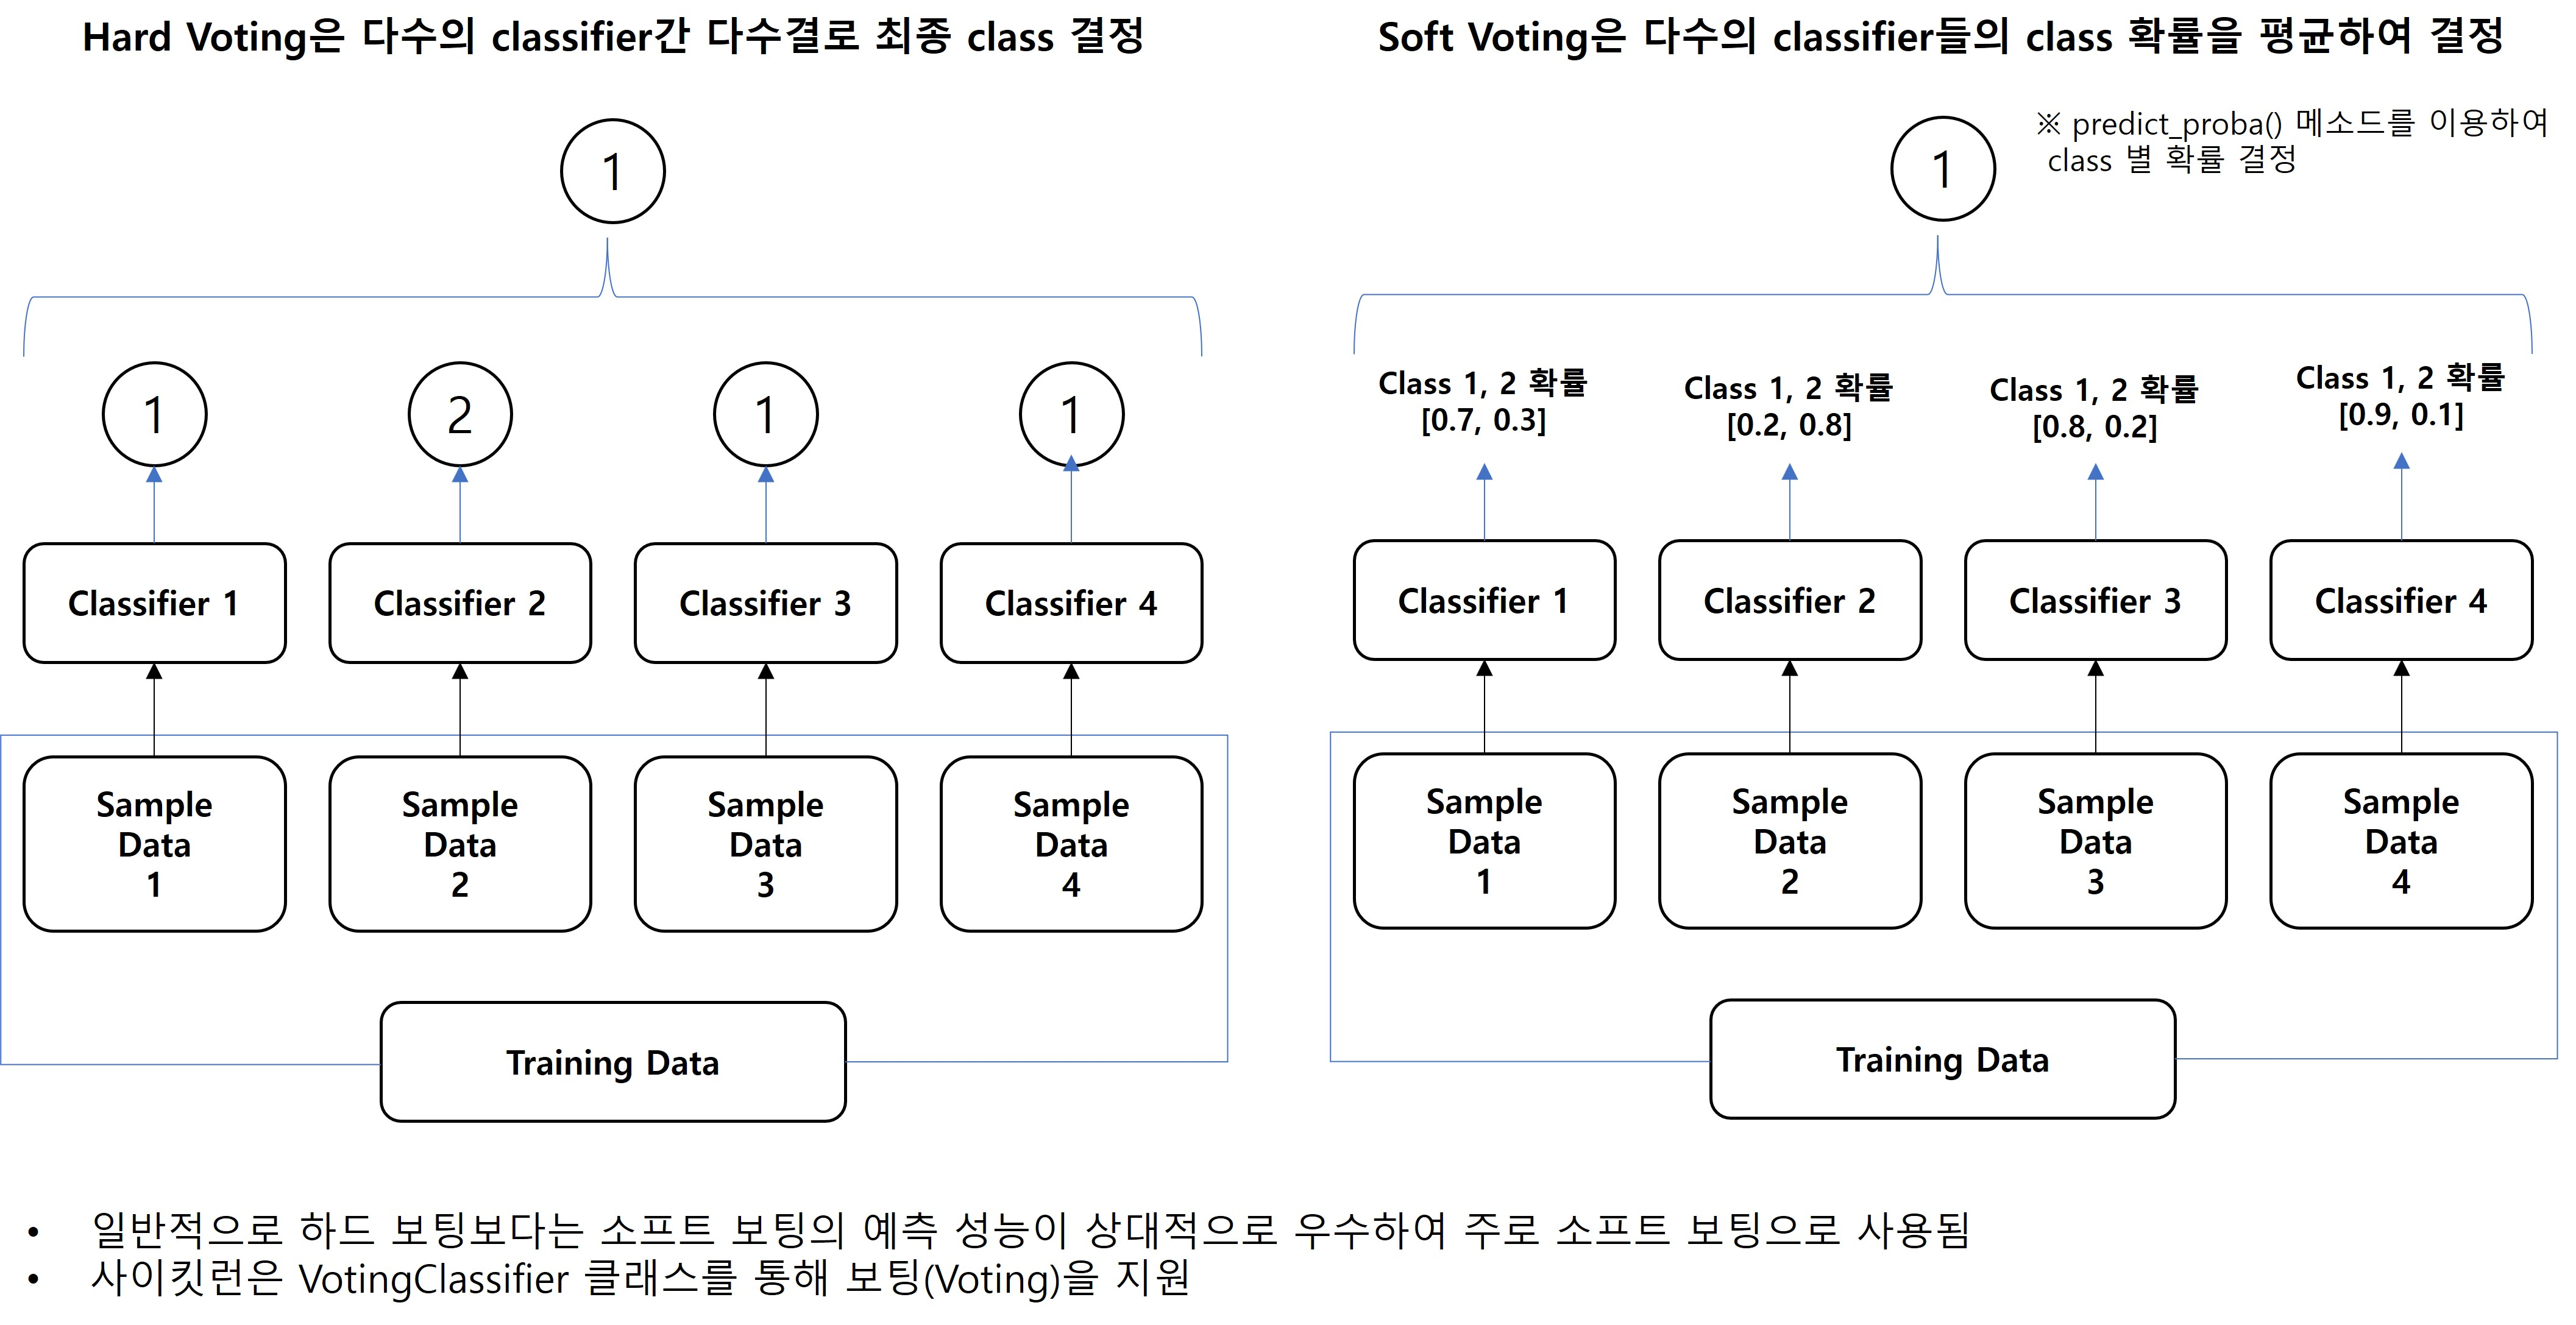

In [2]:
Image('voting2.jpg', width = 500)

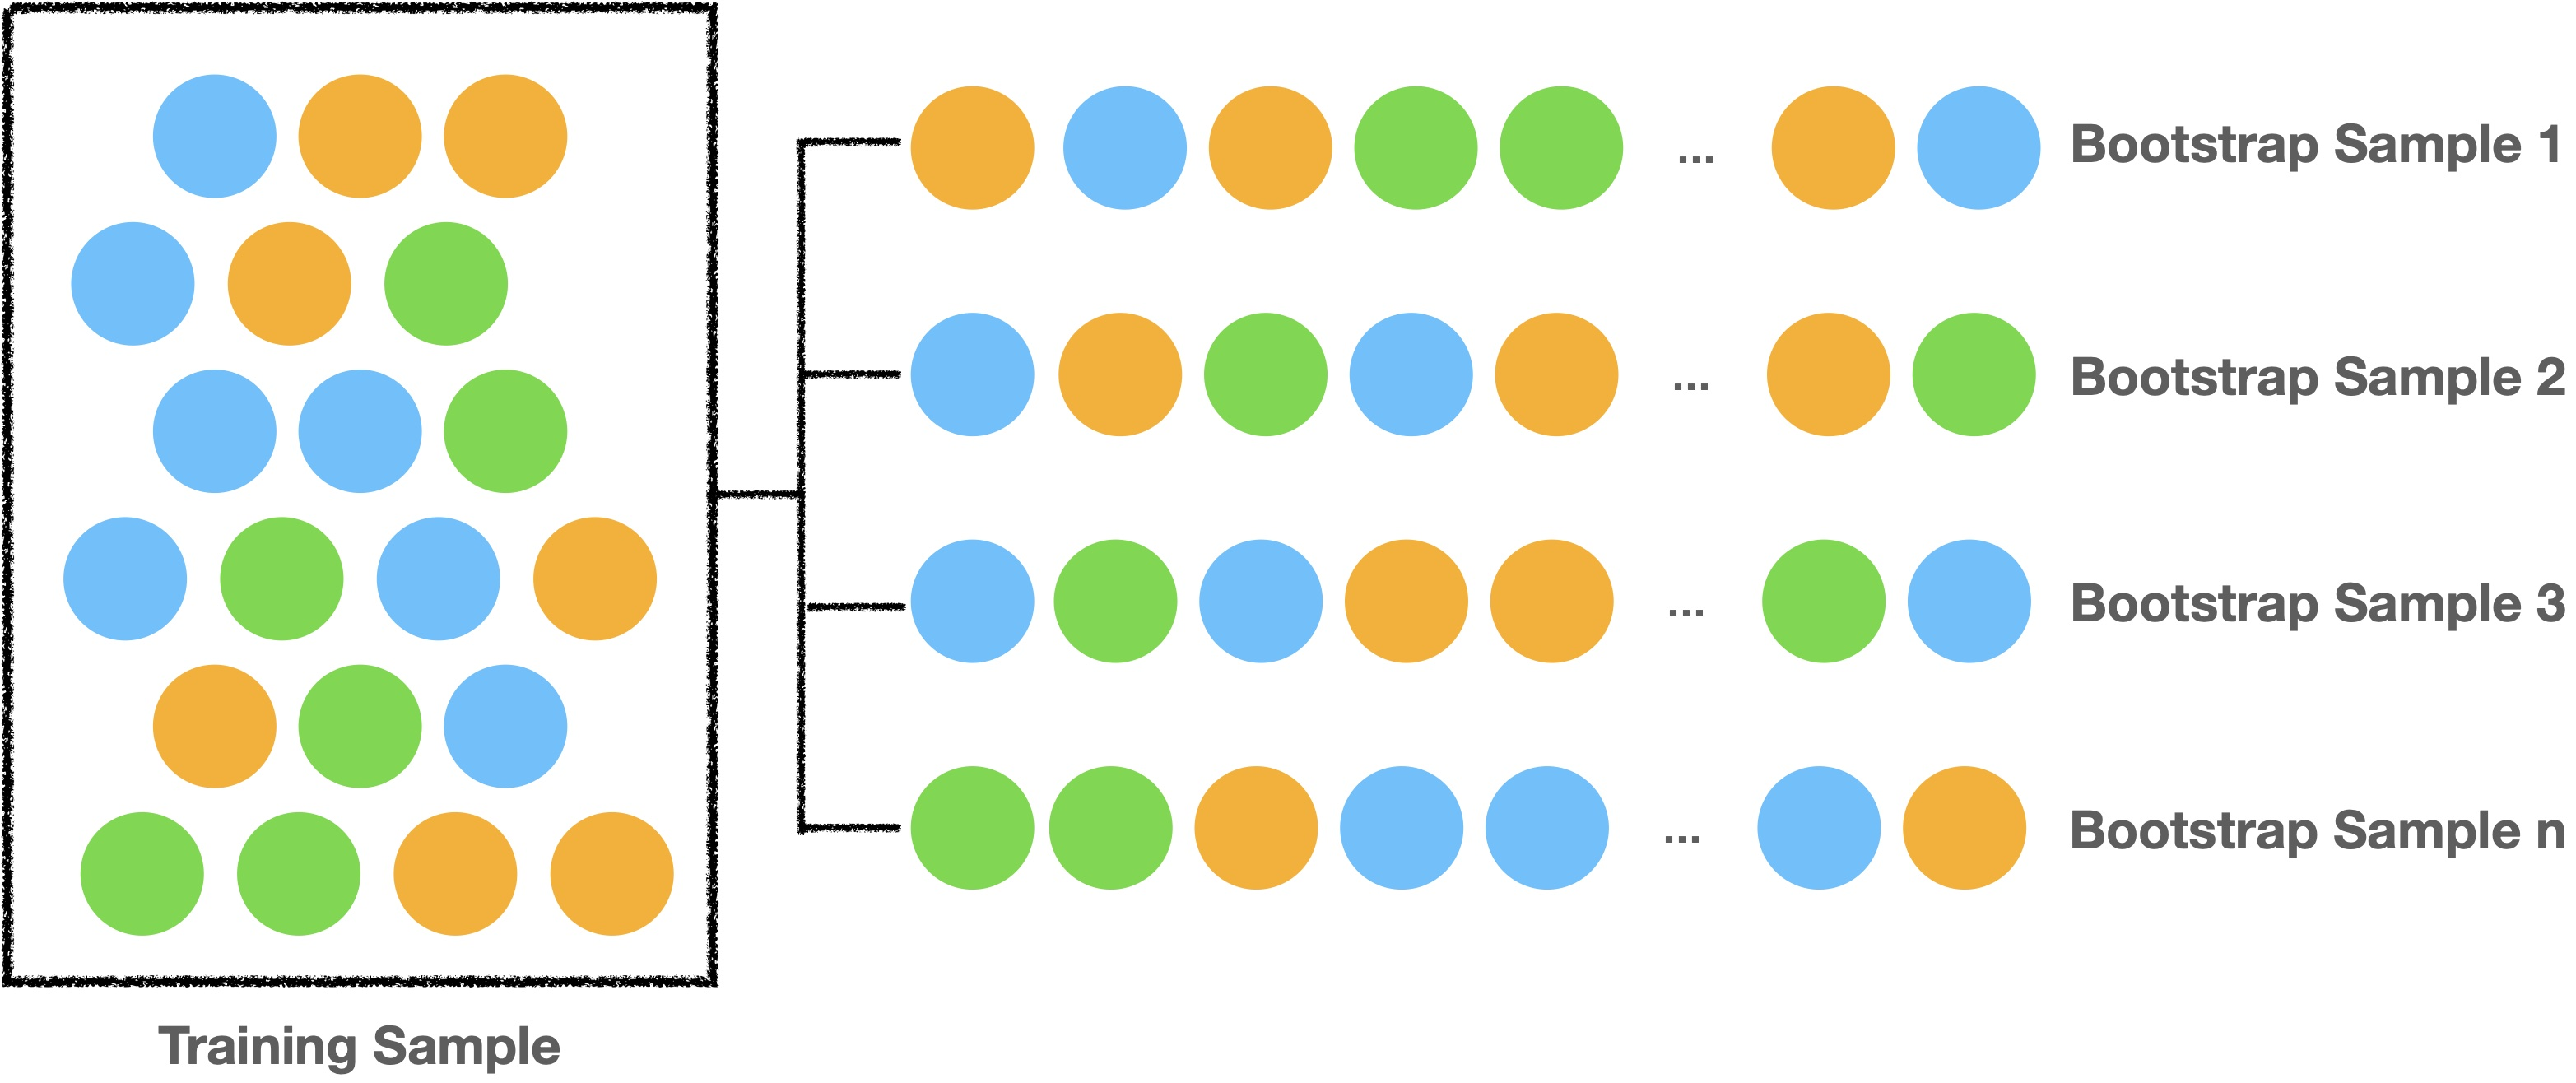

In [3]:
Image('bagging.jpg', width = 500)

In [1]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

cancer = load_breast_cancer()

data = pd.DataFrame(cancer.data, columns = cancer.feature_names)
data.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [3]:
# 개별 모델은 로지스틱 회귀와 KNN
lr_clf = LogisticRegression(solver = 'liblinear')
knn_clf = KNeighborsClassifier(n_neighbors = 8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size = 0.2, random_state = 156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도 : {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도 : 0.9561
LogisticRegression 정확도 : 0.9474
KNeighborsClassifier 정확도 : 0.9386


### Random Forest
- bagging을 사용하는 대표적인 알고리즘
- 같은 결정트리 classifier들이 샘플링 된 개별 데이터 서브세트를 학습한 뒤, 각각의 class에 대한 평균을 계산하여 최종 예측값을 도출

In [24]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    # cumcount()로 중복된 데이터 확인. 0인 경우 중복되지 않음
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    
    #중복된 데이터의 경우 column_name 뒤에 중복 카운트를 붙이고, 중복되지 않은 데이터는 그대로 삽입
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('../human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('../human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('../human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('../human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('../human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()를 사용해 train/test DataFrame return
X_train, X_test, y_train, y_test = get_human_dataset()

# random forest 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0, max_depth = 8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('Random Forest Accuracy : {0:.4f}'.format(accuracy))

Random Forest Accuracy : 0.9196


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split' : [2, 8, 16]
}

# RandomForestClassifier 객체 생성 후 GirdSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 0, j_jobs = -1)
grid_cv = GridSs